In [1]:
import sys
sys.path.append('/mnt/labshare/Programs/python/HelperFunctions/')
from myfunctions import *
from plottingFunctions import *
from plotlylayouts import *

from scipy.optimize import fsolve, fmin
from scipy.constants import k, h, hbar, e
init_notebook_mode(connected=True)

from IPython.core.display import display, HTML, Image
from wavefunction import *
from wavefunction.wavefunction1d import *
import time
display(HTML(
    '<script>'
        'var waitForPlotly = setInterval( function() {'
            'if( typeof(window.Plotly) !== "undefined" ){'
                'MathJax.Hub.Config({ SVG: { font: "STIX-Web" }, displayAlign: "center" });'
                'MathJax.Hub.Queue(["setRenderer", MathJax.Hub, "SVG"]);'
                'clearInterval(waitForPlotly);'
            '}}, 250 );'
    '</script>'
))

import warnings
warnings.filterwarnings('ignore')

# Data from device E5

In [2]:
datapath = "/mnt/labshare/Experiments/DR2/Data/CJPMF10-CH035/"

### Flux Dependence

This is done with the heterodyne setup, sweeping the DC flux (SRS SIM voltage source), with no fast flux pulses.

** Sweep in positive flux direction **

In [3]:
posfig = py.get_figure('plourdelab', 641)

# Adjust for sideband frequency of 50 MHz
posfig.data[0].x = array(posfig.data[0].x) + .05
posfig.layout.width = 1000
posfig.layout.height = 500
iplot(posfig)

posData = posfig.data[0].z

** Sweep in negative flux direction **

In [4]:
negfig = py.get_figure('plourdelab', 647)
# Adjust for sideband frequency of 100 MHz
negfig.data[0].x = array(negfig.data[0].x) + .1
negfig.layout.width = 1000
negfig.layout.height = 500
iplot(negfig)

negData = negfig.data[0].z

Plotly isn't loading this plot for whatever reason, so here's a screenshot of a VNA scan (instead of above heterodyne plots). This is also with a DC SIM bias only. Note the overlap at ~4.8 GHz.

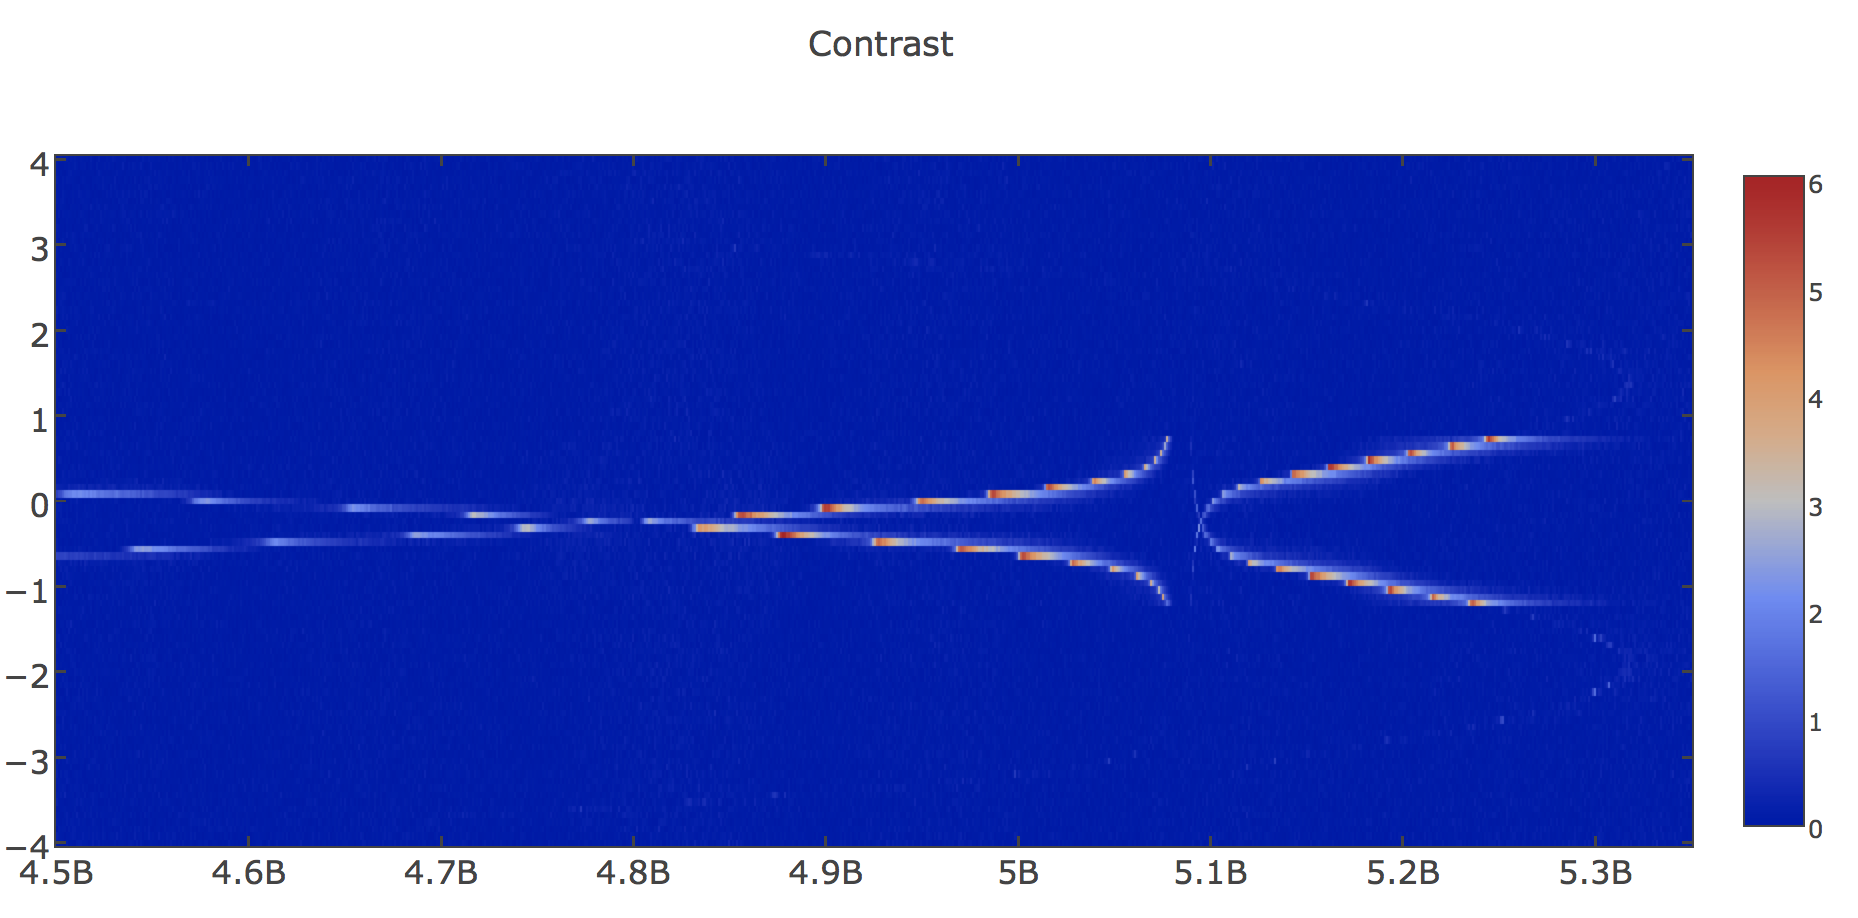

In [5]:
Image('/mnt/labshare/Experiments/DR2/Data/CJPMF10-CH035/Curve Subtraction.png')

### Power Dependence

At room temp, S21 from the rack to the output of the directional coupler gives 84dB of loss at 5 GHz, accounted for as follows:

| Source | Loss (dB) |
|--------|-----------:|
| Fixed Att. | 49 |
| Coupling Loss | 20 |
| Line Loss (CuN @ 5 GHz)| 10 |
| 4m RT cables | 5 |
| **Total**| 84 |

We can use that loss to convert the VNA power to on-chip power.

In [6]:
fig = py.get_figure('plourdelab', 619)
# Add line loss (84dB) to power axis
fig.data[0]['y'] = array(fig.data[0]['y']) - 84
fig.data[0]['x'] = array(fig.data[0]['x'])/1e9
fig.layout.xaxis.title='Frequency (GHz)'
fig.layout.yaxis.title='On-chip drive power (dBm)'
iplot(fig)

### State Separation

* Scope Parameters

In [7]:
dpath = path.join(datapath, '170425')
sCurveSettings = getExpSettings('1874', dpath)
ssSettings = getExpSettings('1880', dpath);
print(json.dumps(sCurveSettings['instruments']['Scope'], indent=4, sort_keys=True))

{
    "acquireMode": "averager",
    "address": "1",
    "averager": {
        "nbrRoundRobins": 5000,
        "nbrSegments": 1,
        "nbrWaveforms": 1,
        "recordLength": 1024
    },
    "clockType": "ref",
    "deviceName": "AgilentAP240",
    "horizontal": {
        "delayTime": 1.5e-07,
        "samplingRate": 1000000000.0
    },
    "trigger": {
        "triggerCoupling": "DC",
        "triggerLevel": 500.0,
        "triggerSlope": "rising",
        "triggerSource": "Ext"
    },
    "vertical": {
        "bandwidth": "Full",
        "verticalCoupling": "AC",
        "verticalOffset": 0.0,
        "verticalScale": 0.1
    }
}


* Demodulation and Integration

In [8]:
print(json.dumps(sCurveSettings['measurements'], indent=4, sort_keys=True))

{
    "Demod": {
        "IFfreq": 100000000.0,
        "bandwidth": 20000000.0,
        "dataSource": "Stream",
        "decimFactor1": 1,
        "decimFactor2": 2,
        "decimFactor3": 1,
        "filterType": "DigitalDemod",
        "phase": 0.0,
        "plotMode": "real/imag",
        "plotScope": true,
        "recordsFilePath": "",
        "samplingRate": 1000000000.0,
        "saveRecords": false,
        "saved": true
    },
    "Integrate": {
        "IFfreq": 100000000.0,
        "bias": 0.0,
        "boxCarStart": 150,
        "boxCarStop": 250,
        "dataSource": "Demod",
        "filterType": "KernelIntegration",
        "kernel": "AAAAAAAA8D8AAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAA8D8AAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAA8D8AAAAAAAA

### Pulse Sequence

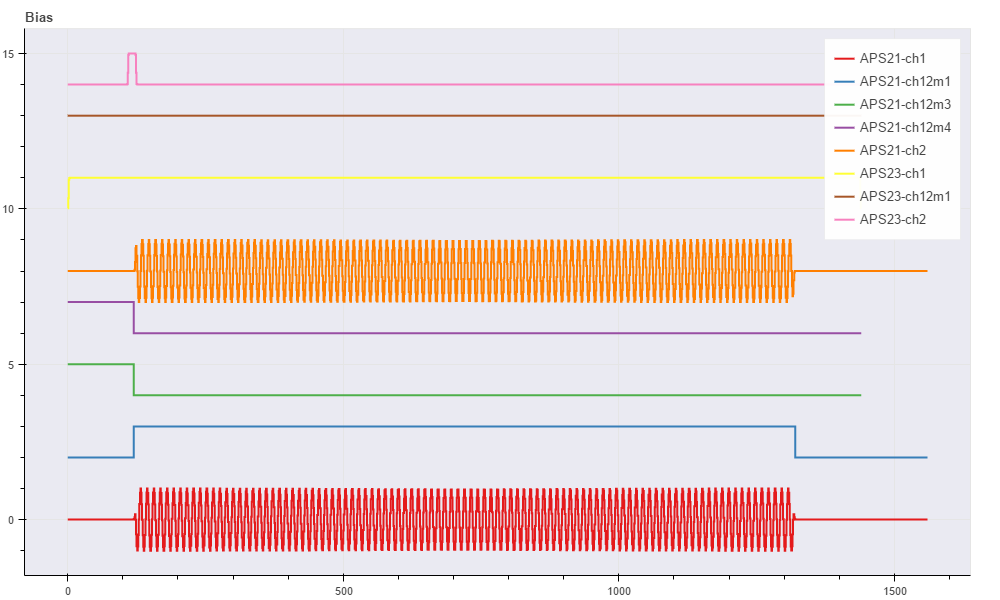

In [23]:
Image('/mnt/labshare/Experiments/DR2/Data/CJPMF10-CH035/Pulses.png')

Here, we are sweeping the park bias amplitude (yellow pulse) while probing at 4.7 GHz, to find the bottom of the dip. The JPM is being reset to its highest frequency in between each experiment (static DC voltage during entire experiment). The tipping pulse (pink pulse above) is turned off. 

In [9]:
fcurve = plotH5File('1882', dpath=dpath)

Here we are sweeping the tipping bias pulse while parked at the dip found above. Data is averaged 5000 times.

In [10]:
scurve = plotH5File('1883', dpath=dpath)
noswitch = plotH5File('1884', dpath=dpath, plot=False)
switch = plotH5File('1885', dpath=dpath, plot=False)

We can now generate IQ blobs by performing a thousand  single-shot reptitions of the above experiment at both 0V and 0.75V tipping pulses. 

In [11]:
ssSettings['instruments']['APS23']

{'address': '192.168.2.4',
 'chan_1': {'amplitude': 0.54, 'enabled': True, 'offset': 0.0},
 'chan_2': {'amplitude': 0.75, 'enabled': True, 'offset': 0.0},
 'delay': 0.0,
 'deviceName': 'APS2',
 'isMaster': False,
 'numChannels': 2,
 'samplingRate': 1200000000.0,
 'seqFile': 'Z:/Experiments/DR2/pyqlab-config/AWG/Bias/Bias-APS23.h5',
 'seqForce': True,
 'triggerInterval': 0.0001,
 'triggerSource': 'External'}

In [22]:
layout, trace1 = LinePlot(x=switch['y']['real'], y=switch['y']['imag'])
trace1.update(mode='markers', name="Switch")

layout, trace2 = LinePlot(x=noswitch['y']['real'], y=noswitch['y']['imag'])
trace2.update(mode='markers', name="No Switch")
layout.xaxis.update(title='Real (I)', range=[-10, 10])
layout.yaxis.update(title='Imag (Q)', range=[-10, 10])
layout.update(autosize=False, width=1000, height=800)
iplot(Figure(data=[trace1, trace2], layout=layout))

switchiq = switch['y']['real'] + 1j*switch['y']['imag']
noswitchiq = noswitch['y']['real'] + 1j*noswitch['y']['imag']


print("Switch\n\t I: {:f} +/ {:f} \n\t Q: {:f} +/ {:f}\n\t Amp: {:f}"
      .format(mean(real(switchiq)), std(real(switchiq)), 
        mean(imag(switchiq)), std(imag(switchiq)),
        sqrt(mean(real(switchiq))**2 + mean(imag(switchiq))**2)))

print("No Switch\n\t I: {:f} +/ {:f} \n\t Q: {:f} +/ {:f}\n\t Amp: {:f}"
      .format(mean(real(noswitchiq)), std(real(noswitchiq)), 
        mean(imag(noswitchiq)), std(imag(noswitchiq)),
        sqrt(mean(real(noswitchiq))**2 + mean(imag(noswitchiq))**2)))

Switch
	 I: 5.639875 +/ 1.475751 
	 Q: 3.909764 +/ 1.471628
	 Amp: 6.862540
No Switch
	 I: 4.566194 +/ 1.468848 
	 Q: 3.075557 +/ 1.464429
	 Amp: 5.505377


## RF Squid Model


In an RF squid,

$$
\frac{f(\phi)}{f_{max}} = \sqrt{cos{\phi}}
$$
so
$$
\phi = \cos^{-1}{\left(\frac{f(\phi)}{f_{max}}\right)^2}
$$

and

$$
\phi = \phi_x - \beta_L\sin{\phi}
$$

where

$$
\beta_L = \frac{2\pi L I_0}{\Phi_0}
$$

At the point where both wells are equal ($f_{cross}$), $\phi_x = \pi$

For this device, $f_{max}=5.3\mathrm{GHz}$, $f_{cross} = 4.8\mathrm{GHz}$. 

Plugging in,

In [13]:
fmax = 5.3
fcross = 4.8

phicross = arccos((fcross / fmax)**2)
betaL = (pi - phicross) / sin(phicross)

print("phi_cross = {:f} rad".format(phicross))
print("betaL = {:f}".format(betaL))

phi_cross = 0.609000 rad
betaL = 4.427245


Now we can use the calculated $\beta_L$ to plot the JPM spectrum at all external flux points.

In [16]:
# One period of flux/phase
phi = 1 * 2*pi*linspace(-1, 1, 1001)

# Solve for a given external flux
def phisolve(phi, *args):
    # args = [phix, betaL]
    return args[0] - phi - args[1]*sin(phi)

phis = []

for ph in phi:
    phisol = fsolve(phisolve, phicross, args=(ph, betaL))[0]
    phis.append(phisol)
    
x = phi/(2*pi) # Normalize
y = fmax*sqrt(cos(phis))

traces = []

# Plot a few branches

for period in range(-2, 2):
    layout, trace = LinePlot(x=x + period, y=y, title="$ \\text{JPM Simulated Frequencies with } \\beta_L = 4.4$")
    traces.append(trace)
    
layout.yaxis.range = [4.5, 5.35]
layout.xaxis.title = "$ \\Phi/\\Phi_0$"
layout.yaxis.title = "$\\text{Frequency (GHz)}$"
layout.showlegend = False

iplot(Figure(data=traces, layout=layout))

This looks similar enough to the measured JPM frequencies, and is comparable to the $\beta_L$ of 4.8 for the device being measured in Madison. 